# DATASCI W261, Machine Learning at Scale
--------
#### Assignement:  week \#7
#### Shih Yu Chang
### Due: 2016-10-25, 8AM PST

In [282]:
import numpy as np
from __future__ import division
import os
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

%reload_ext autoreload
%autoreload 2

# HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target. Work locally for this part of the assignment, and use both of the undirected and directed toy networks.

![Toy networks](toy_graphs.png)

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output -- make sure it is correct!

In [283]:
%%writefile MRJob_Initiate.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys

class initiate(MRJob):

    # Specify initial node conditions
    def configure_options(self):
        super(initiate, self).configure_options()
        self.add_passthrough_option('--startNode', default='1')

    def mapper(self, _, line):
        fields = line.strip().split('\t')
        name = fields[0]
        neighbors = eval(fields[1])
        if name == self.options.startNode:
            yield name, [neighbors, 0, [name], 'Q']
        else:
            yield name, [neighbors, sys.maxint, [], 'U']

if __name__ == '__main__':
    initiate.run()

Overwriting MRJob_Initiate.py


In [284]:
%%writefile MRJob_ShortestPath.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys

class shortestPath(MRJob):

    
    def mapper(self, _, line):

        # Split text to get our data
        fields = line.strip().split('\t')

       
        name = str(eval(fields[0]))
        value = eval(fields[1])
        neighbors = value[0]
        distance = int(value[1])
        path = value[2]
        status = value[3]
        

        # If this node is queued, contine explore next level
        if status == 'Q':
            yield name, [neighbors, distance, path, 'V']
            if neighbors:
                for node in neighbors:
                    temp_path = list(path)
                    temp_path.append(node)
                    yield node, [None, distance + 1, temp_path, 'Q']
        else:
            yield name, [neighbors, distance, path, status]


 
    def reducer(self, key, values):
        neighbors = {}
        distance = sys.maxint
        status = None
        path = []

        for val in values:

            # We've hit a visited node. Break out of the loop.
            if val[3] == 'V':
                neighbors = val[0]
                distance = val[1]
                path = val[2]
                status = val[3]
                break

            # We've hit an unvisited node. Collect the neighbors and the status
            # If status is already Q, do not overwrite
            elif val[0]:
                neighbors = val[0]
                if status != 'Q':
                    status = val[3]

            # We've hit a queued node. Update status and path
            else:
                path = val[2]
                status = val[3]
                

            # Update minimum distance if necessary
            distance = min(distance, val[1])

        yield key, [neighbors, distance, path, status]

if __name__ == '__main__':
    shortestPath.run()

Overwriting MRJob_ShortestPath.py


In [285]:
from MRJob_Initiate import initiate
from MRJob_ShortestPath import shortestPath

def findShortestPath(filename, startNode, finalNode):
    temp_dir = 'w261_temp/' + os.path.dirname(filename)
    !mkdir -p $temp_dir

    filenameState = 'w261_temp/' + filename

    # Initiate graph adjacency list to track state
    mr_job_init = initiate(args=[
        filename, '-r', 'local',
        '--no-strict-protocols',
        '--startNode', startNode
    ])

    with open(filenameState, 'w') as myfile:
        with mr_job_init.make_runner() as runner:
            runner.run()

            for line in runner.stream_output():
                out = mr_job_init.parse_output_line(line)
                myfile.write(str(out[0]) + '\t' + str(out[1]) + '\n')

    # Iterate over the adjacency list with state until all nodes are visited
    filenameTemp = filenameState + '.tmp'

    mr_job = shortestPath(args=[
        filenameState,
        '--no-strict-protocols'
    ])

    for i in range(10):
        with open(filenameTemp, 'w') as myfile:
            with mr_job.make_runner() as runner:
                # Run MRJob
                runner.run()

                # Write stream_output to file
                for line in runner.stream_output():
                    out = mr_job.parse_output_line(line)
                    myfile.write(str(out[0]) + '\t' + str(out[1]) + '\n')

                    if out[0] == finalNode and out[1][3] == 'V':
                        path = out[1][2]
                        return path

        !mv {filenameTemp} {filenameState}

In [286]:
filename = 'undirected_toy.txt'
print 'Shortest path in', filename
path = findShortestPath(filename, '1', '4')
print path

filename = 'directed_toy.txt'
print '\nShortest path in', filename
path = findShortestPath(filename, '1', '5')
print path

Shortest path in undirected_toy.txt
['1', '5', '4']

Shortest path in directed_toy.txt
['1', '2', '4', '5']


# HW 7.1: Exploratory data analysis (NLTK synonyms)

For the NLTK data set, find:
- Number of nodes
- Number of links
- Average degree

In [287]:
%%writefile MRJob_Network_EDA.py
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep

class Network_EDA(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    # Define some users options 
    def configure_options(self):
        super(Network_EDA, self).configure_options()
        self.add_passthrough_option('--Network_EDA_Type', default='nodes')

    
    # Find number of nodes
    
    def mapper_discoverNodes(self, name, neighbors):
        yield str(name), 1
        for node in neighbors:
            yield str(node), 1

    def reducer_discoverNodes(self, key, value):
        yield key, 1

    def mapper_countNodes(self, key, value):
        yield None, 1

    def reducer_countNodes(self, key, value):
        yield None, sum(value)

    
    #Find the distribution of out degrees
    

    def mapper_links(self, name, neighbors):
        degree = len(neighbors)
        yield degree, 1

    def reducer_links(self, degree, occurrences):
        yield degree, sum(occurrences)

    
    # Perform different EDA tasks
    

    def steps(self):
        if self.options.Network_EDA_Type == 'nodes':
            return [
                MRStep(mapper=self.mapper_discoverNodes,
                       combiner=self.reducer_discoverNodes,
                       reducer=self.reducer_discoverNodes),
                MRStep(mapper=self.mapper_countNodes,
                       combiner=self.reducer_countNodes,
                       reducer=self.reducer_countNodes)
            ]
        elif self.options.Network_EDA_Type == 'links':
            return [
                MRStep(mapper=self.mapper_links,
                       combiner=self.reducer_links,
                       reducer=self.reducer_links)
            ]

if __name__ == '__main__':
    Network_EDA.run()

Overwriting MRJob_Network_EDA.py


In [288]:
from __future__ import division
from MRJob_Network_EDA import Network_EDA
import numpy

def Network_EDA_Data(runnerType, filename):

    # Compute the node count

    mr_job = Network_EDA(args=[
        filename, '-r', runnerType,
        '--no-strict-protocols',
        '--Network_EDA_Type', 'nodes'
    ])

    

    with mr_job.make_runner() as runner:
        runner.run()

        for line in runner.stream_output():
            out = mr_job.parse_output_line(line)
            nodes = out[1]

    # Compute the distribution of the links

    mr_job = Network_EDA(args=[
        filename, '-r', runnerType,
        '--no-strict-protocols',
        '--Network_EDA_Type', 'links'
    ])

    temp_file = os.path.basename(filename) + '.histogram'
    temp_dir = 'w261_temp/' + os.path.dirname(filename)

    !mkdir -p $temp_dir

    with open(temp_dir + '/' + temp_file, 'w') as histogram_file:
        with mr_job.make_runner() as runner:
            runner.run()

            for line in runner.stream_output():
                print >> histogram_file, line.strip()

    # Print the summary

    data_file = numpy.loadtxt(temp_dir + '/' + temp_file)
    bins, weights = data_file.astype(int).T
    #print bins  
    #print weights[::-1]

    links = int( 0.5 * numpy.sum([int(degree * weight) for degree, weight in data_file]))

    print 'Number of nodes =', '{:,d}'.format(nodes)
    print 'Number of links =', '{:,d}'.format(links)
    print 'Average degree  =', '{:,.2f}'.format(links / nodes)

    temp_dir = 'w261_temp/' + os.path.dirname(filename)
    temp_file = os.path.basename(filename) + '.histogram'

    # degree histogram

    fig = matplotlib.pyplot.figure(figsize=(15, 5))

    plot = fig.add_subplot(1, 2, 1)
    plot.set_xlabel("Degrees")
    plot.set_ylabel("Frequency")
    plot.set_title("Histogram of Degrees")
    plot.hist(bins, 20, weights = weights, color='r')

    # log-log plot 

    log_bins = numpy.log(bins)
    log_weights = numpy.log(weights)
    log_plot = fig.add_subplot(1, 2, 2)
    log_plot.set_xlabel('log(Degrees)')
    log_plot.set_ylabel('log(Frequency)')
    log_plot.set_title('Log-Log Plot of Histogram of Degrees')
    log_plot.hist(log_bins, 20, weights = log_weights, color='r')

In [289]:
import functools

Network_EDA_DataInline = functools.partial(Network_EDA_Data, 'inline')

Undirected toy data
Number of nodes = 5
Number of links = 7
Average degree  = 1.40


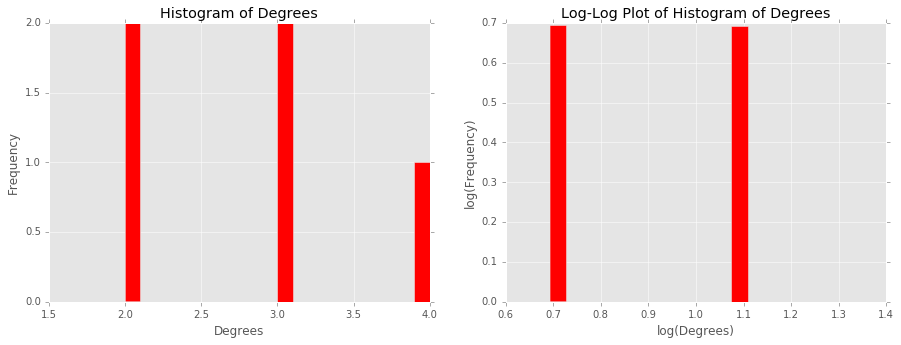

In [290]:
print 'Undirected toy data'
Network_EDA_DataInline('undirected_toy.txt')


Directed toy data
Number of nodes = 6
Number of links = 6
Average degree  = 1.00


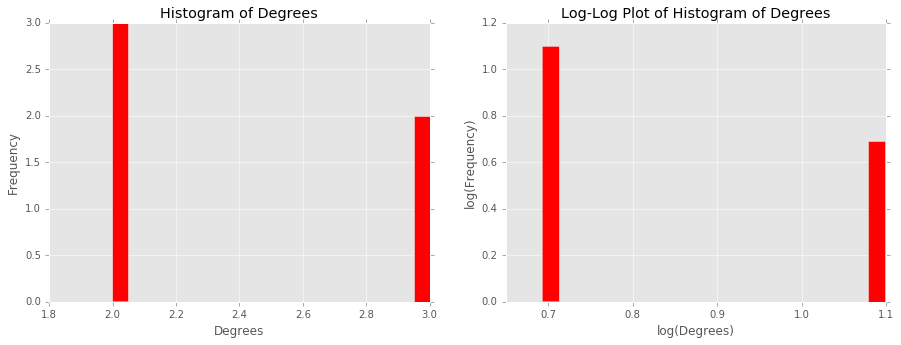

In [291]:
print '\nDirected toy data'
Network_EDA_DataInline('directed_toy.txt')

NLTK data
Number of nodes = 8,271
Number of links = 30,567
Average degree  = 3.70


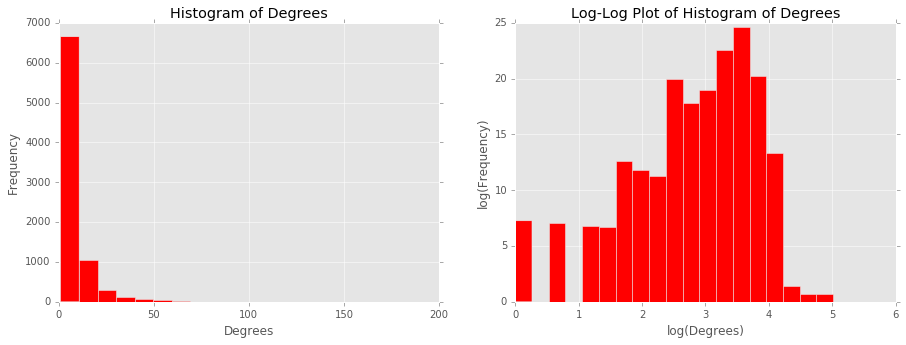

In [292]:
print 'NLTK data'
Network_EDA_DataInline('synNet.txt')

## Problem 7.2 - Shortest Path on Synonym Network

In [293]:
def printPath(indexFile, path):
    path_Dict = {}
    pathSet = set(path)

 
    with open(indexFile, 'r') as myfile:
        for line in myfile:
            fields = line.strip().split('\t')

           
            if fields[1] in pathSet:
                path_Dict[fields[1]] = fields[0]

    print '{:<10s}{:<50s}'.format('INDEX', 'NAME')
    distance = 0
    for node in path:
        distance = distance + 1
        print '{:<10s}{:<50s}'.format(node, path_Dict[node])
    print 'Total Distance is ', '{:,d}'.format(distance - 1)

In [294]:
filename = 'synNet.txt'
path = findShortestPath(filename, '7827', '536')
printPath('indices.txt', path)

INDEX     NAME                                              
7827      walk                                              
4655      passes                                            
631       draw                                              
536       make                                              
Total Distance is  3


## Try at Hadoop

In [295]:
hadoopBaseDir = '/user/shihyu'

In [306]:
from datetime import datetime
from MRJob_Initiate import initiate
from MRJob_ShortestPath import shortestPath

def findShortestPathHadoop(filename, startNode, endNode):
    global hadoopBaseDir

    # Set the name of our output folder, and make sure it does not already exist
    outputDirName = filename.replace('.txt', '_state2').split('/')[-1]
    outputDirState = 'hdfs://%s/%s' % (hadoopBaseDir, outputDirName)

    !hdfs dfs -rm -r -f -skipTrash $outputDirState > /dev/null

    print datetime.today(), 'Initializing adjacency list'

    # Initiate graph adjacency list to track state
    mr_job_init = initiate(args=[
        filename,
        '--strict-protocols',
        '--startNode', startNode,
        '-r', 'hadoop',
        '--output-dir', outputDirState
    ])

    with mr_job_init.make_runner() as runner:
        runner.run()

    # Iterate over the adjacency list with state until all nodes are visited
    inputDir = outputDirState + '/'
    outputDir = outputDirState + 'Temp1'

    finished = False
    path = None

    i = 1

    while not finished and path is None:
        !hdfs dfs -rm -r -f -skipTrash $outputDir > /dev/null
        print datetime.today(), 'Beginning iteration', i

        mr_job = shortestPath(args=[
            inputDir,
            '--strict-protocols',
            '-r', 'hadoop',
            '--output-dir', outputDir
        ])

        with mr_job.make_runner() as runner:
            # Run MRJob
            runner.run()

            print datetime.today(), 'Completed iteration', i
            finished = True

            # Write stream_output to file
            for line in runner.stream_output():
                out = mr_job.parse_output_line(line)
                if out[0] == endNode and out[1][3] != 'U':
                    path = out[1][2]
                elif out[1][3] == 'Q':
                    finished = False

        # Update inputDir and outputDir for next iteration
        inputDir = outputDirState + 'Temp' + str(i) + '/'
        outputDir = outputDirState + 'Temp' + str(i + 1)

        i += 1

    return path

In [298]:
# Same result as non hadoop implementation
filename = 'synNet.txt'
startNode = '7827'
finalNode = '536'

path = findShortestPathHadoop(filename, startNode, finalNode)
printPath('indices.txt', path)

2016-10-23 07:41:06.321527 Beginning iteration 1
2016-10-23 07:41:49.921911 Completed iteration 1
2016-10-23 07:42:03.855008 Beginning iteration 2
2016-10-23 07:42:44.188641 Completed iteration 2
2016-10-23 07:42:57.688388 Beginning iteration 3
2016-10-23 07:43:42.168284 Completed iteration 3
INDEX     NAME                                              
7827      walk                                              
1426      pass                                              
3651      reached                                           
536       make                                              
Total Distance is  3


# HW 7.3: Exploratory data analysis (Wikipedia)

In [301]:
%%writefile mrjob_7_3.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class DegreeDistribution_7_3(MRJob):
    def steps(self):
        job_conf = {'mapred.reduce.tasks': '1'}
        return [MRStep(mapper = self.degree_mapper,
                       reducer_init = self.degree_reducer_init,
                       reducer = self.degree_reducer,
                       reducer_final = self.degree_reducer_final,
                       jobconf = job_conf
                       )]
    
    # Output the node and its indegree / outdegree
    def degree_mapper(self, _, line):
        line = line.strip('\n')        
        title, node, indegree, outdegree = line.split('\t')
        yield node, (indegree, outdegree)
    
    def degree_reducer_init(self):
        self.indegree_num = {}
        self.outdegree_num = {}
    
    # Gather up how many nodes, how many for indegree and outdegree 
    def degree_reducer(self, key, values):
        for indegree, outdegree in values:
            self.indegree_num.setdefault(indegree, 0)
            self.indegree_num[indegree] += 1
            self.outdegree_num.setdefault(outdegree, 0)
            self.outdegree_num[outdegree] += 1
    
    # Output the final counts and frequencies of the indegree/outdegree counts.
    def degree_reducer_final(self):
        for indegree in self.indegree_num:
            yield 'in', (indegree, self.indegree_num[indegree])
        for outdegree in self.outdegree_num:
            yield 'out', (outdegree, self.outdegree_num[outdegree])


Overwriting mrjob_7_3.py


Number of Nodes in Wikipedia Netork: 15192277
Number of IN Links: 185243029
Number of OUT Links: 185243029
Average Number of IN Links: 12.1932366689
Average Number of OUT Links: 12.1932366689


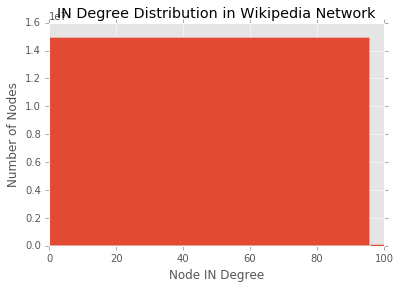

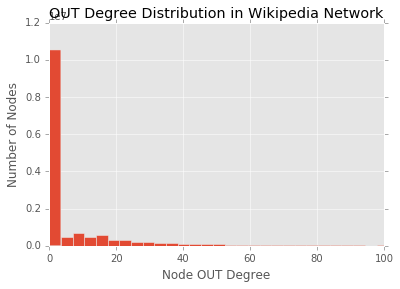

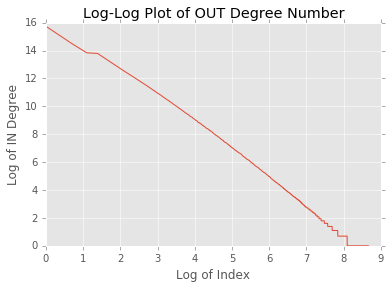

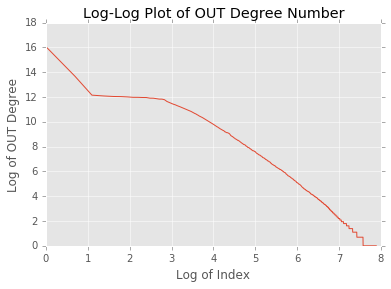

In [302]:
from mrjob_7_3 import DegreeDistribution_7_3
import matplotlib.pyplot as plt
import math


mr_job1 = DegreeDistribution_7_3(args=['indices_wiki.txt', '--no-output', '--no-strict-protocols'])

indegree_num = {}
outdegree_num = {}
with mr_job1.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        degree_type, (degree, num) =  mr_job1.parse_output_line(line)
        if degree_type == 'in':
            indegree_num[int(degree)] = int(num)
        elif degree_type == 'out':
            outdegree_num[int(degree)] = int(num)
            
# Summing up to get total nodes, total indegree and outdegree numbers

total_nodes = 0
total_indegree = 0
for indegree in indegree_num:
    total_nodes += indegree_num[indegree]
    total_indegree += indegree * indegree_num[indegree]
total_outdegree = 0
for outdegree in outdegree_num:
    total_outdegree += outdegree * outdegree_num[outdegree]

print 'Number of Nodes in Wikipedia Netork:', total_nodes
print 'Number of IN Links:', total_indegree
print 'Number of OUT Links:', total_outdegree
print 'Average Number of IN Links:', total_indegree * 1.0 / total_nodes
print 'Average Number of OUT Links:', total_outdegree * 1.0 / total_nodes
    
plt.hist(indegree_num.keys(), len(indegree_num), weights = indegree_num.values())
plt.title('IN Degree Distribution in Wikipedia Network')
plt.xlabel('Node IN Degree')
plt.ylabel('Number of Nodes')
plt.xlim(0, 100)
plt.show()

plt.hist(outdegree_num.keys(), len(outdegree_num), weights = outdegree_num.values())
plt.title('OUT Degree Distribution in Wikipedia Network')
plt.xlabel('Node OUT Degree')
plt.ylabel('Number of Nodes')
plt.xlim(0, 100)
plt.show()

degree = [math.log(float(i)) for i in range(1, len(indegree_num) + 1)]
nodes_number = [math.log(float(v)) for v in sorted(indegree_num.values(), reverse = True)]
plt.plot(degree, nodes_number)
plt.title('Log-Log Plot of OUT Degree Number')
plt.xlabel('Log of Index')
plt.ylabel('Log of IN Degree')
plt.show()

degree = [math.log(float(i)) for i in range(1, len(outdegree_num) + 1)]
nodes_number = [math.log(float(v)) for v in sorted(outdegree_num.values(), reverse = True)]
plt.plot(degree, nodes_number)
plt.title('Log-Log Plot of OUT Degree Number')
plt.xlabel('Log of Index')
plt.ylabel('Log of OUT Degree')
plt.show()

## HW 7.4: Shortest path graph distances (Wikipedia)

In [307]:
# Find distance between:
#  - 'Ireland'
#  - 'University of California, Berkeley'
filename = 'all-pages-indexed-out.txt'
path = findShortestPathHadoop(filename, '6176135', '13466359')
printPath('indices_wiki.txt', path)

2016-10-23 09:04:14.425532 Initializing adjacency list
2016-10-23 09:23:15.054724 Beginning iteration 1
2016-10-23 09:43:10.332581 Completed iteration 1
2016-10-23 09:44:56.855469 Beginning iteration 2
2016-10-23 10:04:49.065379 Completed iteration 2
INDEX     NAME                                              
6176135   Ireland                                           
11607791  Seamus Heaney                                     
13466359  University of California, Berkeley                
Total Distance is  2


## HW 7.5: Conceptual exercise: Largest single-source network distances

## My Trial for Longest Path
## There are multiple ways to define a node as being the furthest away from a single source node. We identify all shortest paths to every node from the source node and from there identify the node that maximizes that shortest path (the all-pairs shortest path problem) as our largest single-source network distances.

In [322]:
def findlargest(filename, source, total):
    max_distance = 0
    max_path = None
    for i in range(1, total + 1):
        path = findShortestPath(filename, source, str(i))
        if (len(path) - 1) > max_distance:
            max_distance = len(path) - 1
            max_path = path
    
    return max_distance, max_path
    
# Toy data model to try
filename = 'undirected_toy.txt' 
source = '5'
total = 5

print(findlargest(filename, source, total))


(2, ['5', '4', '3'])


## HW 7.6: Computational exercise: Largest single-source network

In [332]:
def findlargest_index(filename, indexFile, source, total):
    max_distance = 0
    max_path = None
    for i in range(1, total + 1):
        #print i
        path = findShortestPath(filename, source, str(i))
        if path:
            if (len(path) - 1) > max_distance:
                max_distance = len(path) - 1
                print max_distance
                max_path = path
        else:
            continue
    
    return printPath(indexFile, max_path)
    

filename = 'synNet.txt'
indexFile = 'indices.txt'
source = '1'

# Try only first 20 nodes to verify code

total = 20 

print(findlargest_index(filename, indexFile, source, total))

1
7
8
9
INDEX     NAME                                              
1         A                                                 
2         As                                                
310       ass                                               
586       tail                                              
5494      tracks                                            
3480      running                                           
137       function                                          
226       uses                                              
21        USA                                               
18        AMERICA                                           
Total Distance is  9
None


In [338]:
import time

def findlargest_index(filename, indexFile, source, total):
    max_distance = 0
    max_path = None
    for i in range(1, total + 1):
        #print i
        path = findShortestPath(filename, source, str(i))
        if path:
            if (len(path) - 1) > max_distance:
                max_distance = len(path) - 1
                print max_distance
                max_path = path
        else:
            continue
    
    return printPath(indexFile, max_path)
    
start = time.time()
    
filename = 'synNet.txt'
indexFile = 'indices.txt'
source = '1'

# Total data of synNet.txt 8271

total = 8271

print(findlargest_index(filename, indexFile, source, total))

end = time.time()
countTime = end-start

print countTime
# If the source index is "1", the largest distance found is 9.

1
7
8
9


KeyboardInterrupt: 